# Exercises 8 - Decision Trees, Ensemble Methods, Random Forests 
This lab session is composed of two main parts:

1. We will examine the decision boundaries and overfitting of **Decision Tree** classifiers. Then, we will conduct a **Grid Search** to find optimum hyperparameters for our model. TIP: You will probably want to apply the Grid/Randomized Search to fine-tune your future models.
2. We will witness the *wisdom of the crowd* by analysing various **Ensemble Learning** methods. First, we'll start with *Voting Classifier*, *Bagging*, *Pasting*, *Random Forests* for classification. Then, we will move on to regression and we will see how we can boost a base Decision Tree regressor with *AdaBoost* and *Gradient Boosting*.

We start by importing the usual libraries.

In [1]:
import math 
from typing import List

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split

We will use the same random seed through all exercises for the sake of reproducability of the results.

In [2]:
RANDOM_SEED = 0

# Decision Trees

We will first work with the familiar [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set).

In [3]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)

Let's choose two features to work with and get the target classes.

In [4]:
X = iris.data[["petal length (cm)" , "petal width (cm)"]].to_numpy()
y = iris.target.to_numpy()

We create Training and Test sets. Note the random state parameter.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

## Decision boundaries and accuracy with different tree depths

We define a function to visualize the decision boundaries for a two-feature dataset.
> Just have an idea what the function does, you will only be asked to use it as-is.

In [6]:
CMAP = plt.cm.tab10  # Color palette

def plot_decision_boundaries2D(clf: object, X_train, X_test, y_train, y_test, xlabel="X1", ylabel="X2", 
                               plot_train=True, plot_test=True, cmap: ListedColormap=CMAP):
    """Plots the decision boundaries and training and test data points."""
    n_new_points = 100
    X = np.vstack((X_train, X_test))
    x1, x2 = X[:, 0], X[:, 1]
    x1s = np.linspace(math.floor(x1.min()), math.ceil(x1.max()), n_new_points)
    x2s = np.linspace(math.floor(x2.min()), math.ceil(x2.max()), n_new_points)
    x1_new, x2_new = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1_new.ravel(), x2_new.ravel()]
    y_pred = clf.predict(X_new).reshape(x1_new.shape)
    
    # Plot Training data points
    if plot_train:
        plt.scatter(X_train[:, 0], X_train[:, 1], c=cmap(y_train), alpha=0.3,
                    marker="o", label="Training")
    # Plot Test data points
    if plot_test:
        miss = y_test != clf.predict(X_test)
        plt.scatter(X_test[~miss][:, 0], X_test[~miss][:, 1], c=cmap(y_test[~miss]), edgecolor="k", 
                    marker="o", label="Test correctly classified")
        plt.scatter(X_test[miss][:, 0], X_test[miss][:, 1], c=cmap(y_test[miss]), edgecolor="r",
                    marker="D", label="Test misclassified")
    # Plot Decision Boundaries
    plt.contourf(x1_new, x2_new, y_pred, alpha=0.05)
    # Configure plot
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim([x1s.min(), x1s.max()])
    plt.ylim([x2s.min(), x2s.max()])
    plt.suptitle(f"Decision boundaries of the '{clf.__class__.__name__}''")
    plt.title("with Training and Test data points")
    if plot_train or plot_test:
        plt.legend()


<font color=blue>Fit a [`sklearn.tree.DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) to the Iris training data with the following parameters:<br/>- criterion: `"entropy"`,<br/>- maximum depth: `1`,<br/>- random state: `RANDOM_SEED`.<br/>You may follow the given link to see how the class is used.</font> 

In [7]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

tree_iris1 = DecisionTreeClassifier(criterion="entropy", max_depth=1, random_state=RANDOM_SEED)
tree_iris1.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0)

Let's plot the decision boundaries for the **decision stump** we have just trained.

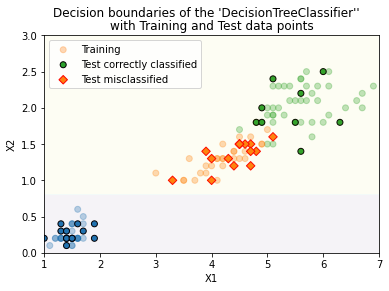

In [8]:
plot_decision_boundaries2D(tree_iris1, X_train, X_test, y_train, y_test)

Now, we plot the tree itself.

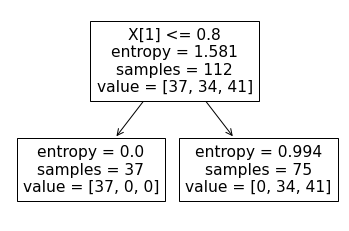

In [9]:
_ = tree.plot_tree(tree_iris1)

<font color=blue>1. How many nodes and how many leaves do you see? <br/> 2. Interpret the entropy in each leaf, i.e. Why high or why low?</font>

---

1. There is a single node because this is a tree of depth=1, a.k.a. a *decision stump*. There are two leaves. 
2. The left leaf's entropy is 0 because all 37 samples are of the same class. The right leaf's entropy is close to 1 because there are many samples from each of the two other classes (34 and 41, respectively).

---

<font color=blue>What is the accuracy of the decision stump on the test set?</font>

In [10]:
from sklearn.metrics import accuracy_score 

accuracy_score(y_test, tree_iris1.predict(X_test))

0.5789473684210527

<font color=blue>Grow another tree with same the training data and parameters above, but this time set the maximum depth to `3`.</font>

In [11]:
tree_iris3 = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=RANDOM_SEED)
tree_iris3.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

We plot the decision boundaries of this tree as well.

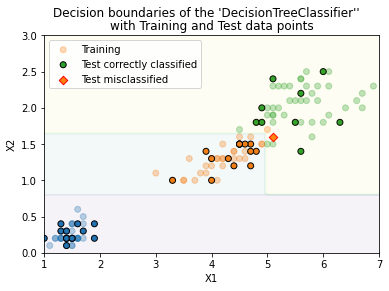

In [12]:
plot_decision_boundaries2D(tree_iris3, X_train, X_test, y_train, y_test)

Let's plot this tree too just for inspection.

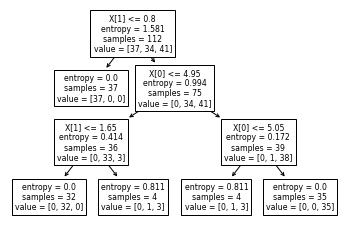

In [13]:
_ = tree.plot_tree(tree_iris3)

<font color=blue>What is the accuracy of the new tree `tree_iris3` on the test set?</font>

In [14]:
accuracy_score(y_test, tree_iris3.predict(X_test))

0.9736842105263158

You should see that the accuracy has increased drastically with a tree of depth=3.

<font color=blue>Now, fit the last tree to the same training data and with the same parameters above but this time set the maximum depth to `5`. Then, calculate its accuracy on the test set.</font>

In [15]:
tree_iris5 = DecisionTreeClassifier(criterion="entropy", max_depth=5, random_state=RANDOM_SEED)
accuracy_score(y_test, tree_iris5.fit(X_train, y_train).predict(X_test))

0.9473684210526315

<font color=blue>Interpret `tree_iris5`'s accuracy with respect to `tree_iris3`.</font>

---

The accuracy on the test set has decreased. This is because, with `max_depth=5`, the last tree has overfit the training data. A tree of depth 3 is expected to generalize better for this dataset.

---

## Search for best tree hyperparamaters

*TIP: You can apply the [Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) method that we will see here to other ML algorithms to find their hyperparameters. Compare it with the [Randomized Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). Sometimes, you may want to use a combination of these two methods. The latter for exploration, the former for exploitation of the hyperparameter space.*

We start by creating a new dataset. We use `scikit-learn`'s [`make_moons`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function that produces two interleaving half circles.

In [16]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.3, random_state=RANDOM_SEED)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

We plot the new training set.

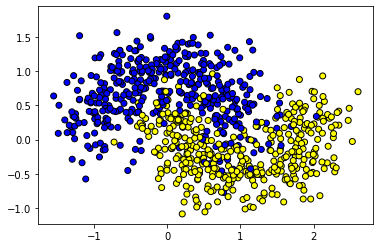

In [17]:
_ = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=ListedColormap(["#0000FF", "#FFFF00"]), edgecolors="k")

We define a short function that gives info about a tree.

In [18]:
def tree_info(tree_):
    """Print brief insights of the tree."""
    print("depth:", tree_.get_depth(), ", n_leaves:", tree_.get_n_leaves())

<font color=blue>Fit a tree to the Moons training data and with no tree limitations. Just set the random state to `RANDOM_SEED` for the sake of reproducibility. Then, calculate the tree's accuracy on the test set.</font>
> Note that since we did not specify the impurity criterion, Scikit-Learn will use the default [*Gini Index*](https://scikit-learn.org/stable/modules/tree.html#classification-criteria), i.e., not the Entropy.

In [19]:
tree_moons = DecisionTreeClassifier(random_state=RANDOM_SEED)
tree_moons.fit(X_train, y_train)
accuracy_score(y_test, tree_moons.predict(X_test))

0.835

Check the depth and number of leaves.

In [20]:
tree_info(tree_moons)

depth: 17 , n_leaves: 97


The decision boundaries plot clearly shows that this tree overfits.

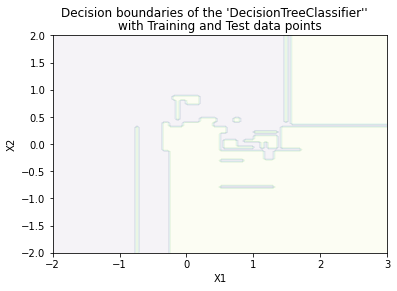

In [21]:
plot_decision_boundaries2D(tree_moons, X_train, X_test, y_train, y_test, plot_train=False, plot_test=False)

Now, we conduct a **grid search** for the best hyperparameters to fit a tree to the above Moons data. We first define the set of possible values for each hyperparameter of interest. For now, we are just interested in limiting the *maximum number of leaves* and *the minimum number of samples required to split an internal node*. We will use 5-fold cross validation for each (parameter 1, parameter 2) pair.
> Just try to understand how a Grid Search is conducted. You will not be asked to modify it.

In [22]:
from sklearn.model_selection import GridSearchCV

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4, 5]}
grid_moons = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_SEED), params, verbose=1, cv=5)

In [23]:
grid_moons.fit(X_train, y_train)

Fitting 5 folds for each of 392 candidates, totalling 1960 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4, 5]},
             verbose=1)

Now, we can get the best estimator tree found in the search. We see that the optimum tree is much shorter.

In [24]:
best_tree_moons = grid_moons.best_estimator_

In [25]:
tree_info(best_tree_moons)

depth: 6 , n_leaves: 9


<font color=blue>Calculate the best tree's accuracy on the test set. The accuracy should be better than the unregularized tree.</font>

In [26]:
accuracy_score(y_test, best_tree_moons.predict(X_test))

0.91

Decision boundaries plot shows that the best tree generalizes much better.

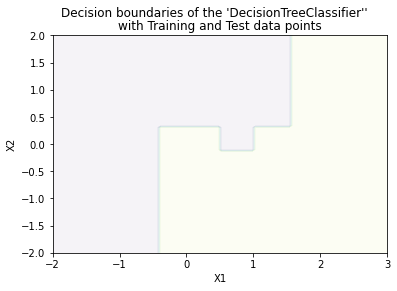

In [27]:
plot_decision_boundaries2D(best_tree_moons, X_train, X_test, y_train, y_test, plot_train=False, plot_test=False)

We will continue to use the moons training and test sets below.

# Ensemble Learning

### The Law of Large Numbers

<font color="blue">You have a biased coin with 51% chance of coming up heads. What are the probabilities (with at least a precision of two decimals) of having a **majority of heads** in 1000 and 10000 independent tosses, respectively?<br/>
HINT: Remember that these were given as ~73% and ~98%, respectively, in the lecture slides and remember also that the number of heads in consecutive (independent) tosses of the same coin follows the [Binomial Distribution](https://en.wikipedia.org/wiki/Binomial_distribution). You can use the online binomial probability calculator [here](https://stattrek.com/online-calculator/binomial) or calculate it yourself with the [`scipy.stats.binom`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html).</font>

---

Let the number of heads is $X$, we know that $X\sim Bin(n, p)$. We are looking for the probability of having majority of heads. This corresponds to the **cumulative probability** of $P(X \ge k)$ where $k$ is the majority number in our question. Formally, 

$$P(X\ge k) = \sum_{i=k}^{n}\binom{n}{i}p^i(1-p)^{n-i}$$ 

We are given $p=0.51$. To find the answer for the first question, we plug in this formula $n=1000$ and $k=501$, and for the second, $n=10000$ and $k=5001$ values. The above online calculator gives the cumulative probabilities as $\mathbf{72.61\%}$ and $\mathbf{97.67\%}$, respectively.

> With `scipy.stats.binom`, you would use` 1. - binom.cdf(k - 1, n, p)` since `binom.cdf(k, n, p)` gives $P(X\le k)$.

---

### Voting Classifier

We will fit a [`sklearn.ensemble.VotingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) that uses the votes of an trio ensemble of Decision Tree, Logistic Regression and Naïve Bayes classifiers.

In [28]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

clf_logreg = LogisticRegression()
clf_nb = GaussianNB()
clf_tree = DecisionTreeClassifier(random_state=RANDOM_SEED)

We first fit the Voting Classifier with *hard voting*, i.e. Majority Vote.

In [29]:
clf_voting_hard = VotingClassifier(
    estimators=[('lr', clf_logreg), ('nb', clf_nb), ('dt', clf_tree)],
    voting='hard')
clf_voting_hard.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()), ('nb', GaussianNB()),
                             ('dt', DecisionTreeClassifier(random_state=0))])

We define a simple function to compare accuracies of different classifiers on the same data, then we call it.

In [30]:
def compare_classifiers_accuracies(clfs: List[object], X_train, X_test, y_train, y_test):
    """Fit each classifier and compare their accuracies."""
    for clf in clfs:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(f"{clf.__class__.__name__}:", accuracy_score(y_test, y_pred))

In [31]:
compare_classifiers_accuracies([clf_logreg, clf_nb, clf_tree, clf_voting_hard], X_train, X_test, y_train, y_test)

LogisticRegression: 0.825
GaussianNB: 0.82
DecisionTreeClassifier: 0.835
VotingClassifier: 0.825


This time, we did not have much luck and the Voting Classifier could not surpass the individual classifiers of this ensemble with the *Majority Vote*.

<font color=blue>Try an ensemble of the same classifiers with *soft voting* instead.</font>

In [32]:
clf_voting_soft = VotingClassifier(
    estimators=[('lr', clf_logreg), ('nb', clf_nb), ('dt', clf_tree)],
    voting='soft')
clf_voting_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()), ('nb', GaussianNB()),
                             ('dt', DecisionTreeClassifier(random_state=0))],
                 voting='soft')

Let's compare all again.

In [33]:
compare_classifiers_accuracies([clf_logreg, clf_nb, clf_tree, clf_voting_soft], X_train, X_test, y_train, y_test)

LogisticRegression: 0.825
GaussianNB: 0.82
DecisionTreeClassifier: 0.835
VotingClassifier: 0.89


<font color=blue>1. What is the new accuracy of the ensemble? <br/>2. Interpret the difference, if any.</font>

---

1. The accuracy of the voting classifier has increased to `0.89`.
2. In soft voting, the classification is made with weighted voting for the classes. The classes with more weights are emphasized, therefore the output is more precise. And in our case, the accuracy of the ensemble exceeded the individual classifiers. Each classifier was good at some parts of the hypothesis space, and thus the aggragetion of their votes yielded a better accuracy than any indivual.

---

### Bagging

<font color=blue>Fit a [`sklearn.ensemble.BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) to the Moons training data above with the following parameters:<br/>- Use `100` Decision Tree classifiers;<br/>- Use `200` samples to train each tree (i.e. 25% of the original training set);<br/>- Use bagging, not pasting;<br/>- Set out-of-bag-evaluation to `True` for validation purpose;<br/>- Set `n_jobs=-1` to use all available processors;<br/>- Set the random state of the BaggingClassfier to `RANDOM_SEED`.</font> 

In [34]:
from sklearn.ensemble import BaggingClassifier

clf_bagging = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    n_estimators=100,
    max_samples=int(len(X_train)*0.25),  # 200
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=RANDOM_SEED
)

clf_bagging.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=200,
                  n_estimators=100, n_jobs=-1, oob_score=True, random_state=0)

Let's see the out-of-bag evaluation score. Remember from the lecture that this score is kind of a validation score.

In [35]:
clf_bagging.oob_score_

0.91625

<font color=blue>Calculate the accuracy of this ensemble on the test set. Observe that the test score is close to the validation (OOB) score.</font>

In [36]:
accuracy_score(y_test, clf_bagging.predict(X_test))

0.915

<font color=blue>Compare the accuracy of the Bagging Ensemble to the single `best_tree_moons`'s accuracy you calculated above.</font>

---

The `best_tree_moons` was the best tree to fit the moons data and its test accuracy was `0.91`. In our case, the Bagging Ensemble of `100` trees outperformed the best tree with an accuracy of `0.915`. Note that the ensemble accomplished this although each tree was trained on 25% of the original training data. Also, note that with different settings (e.g., a constraint on the depth of base trees), the ensemble may underperform the best tree. On the other hand, in practice, you usually would not look for the best tree but prefer an ensemble of trees for better generalization.

---

### Random Forests

<font color=blue>Fit a [`sklearn.ensemble.RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to the Moons training data above with the following parameters:<br/>- Grow `100` trees in the forest;<br/>- Use bagging, not pasting;<br/>- Set `n_jobs=-1` to use all available processors;<br/>- Set the random state of the forest to `RANDOM_SEED`.</font> 

In [37]:
from sklearn.ensemble import RandomForestClassifier

clf_rndbag = RandomForestClassifier(
    n_estimators=100, 
    bootstrap=True, 
    n_jobs=-1, 
    random_state=RANDOM_SEED)

clf_rndbag.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

<font color=blue>As usual, calculate the accuracy of this random forest on the test set. Observe that it should not be very different from the above Bagging Ensemble of trees. This is because Random Forest classifier is an (optimized) implementation of a Bagging classifier with trees.</font>

In [38]:
accuracy_score(y_test, clf_rndbag.predict(X_test))

0.905

<font color=blue>Now, fit a random forest with the same parameters as the above forest, but this time use *pasting* instead of bagging. And calculate its accuracy on the test set.</font>

In [39]:
clf_rndpaste = RandomForestClassifier(
    n_estimators=100, 
    bootstrap=False, 
    n_jobs=-1, 
    random_state=RANDOM_SEED)

clf_rndpaste.fit(X_train, y_train)

accuracy_score(y_test, clf_rndpaste.predict(X_test))

0.88

You should see that with pasting the accuracy was lower than the one with bagging. That said, the Random Forest with *pasting* still outperforms the single `tree_moons`.

We plot the decision boundaries of the *bagging* and *pasting* ensembles, respectively.

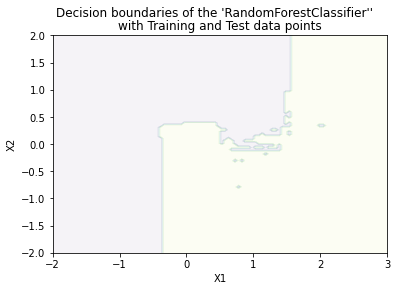

In [40]:
plot_decision_boundaries2D(clf_rndbag, X_train, X_test, y_train, y_test, plot_train=False, plot_test=False)

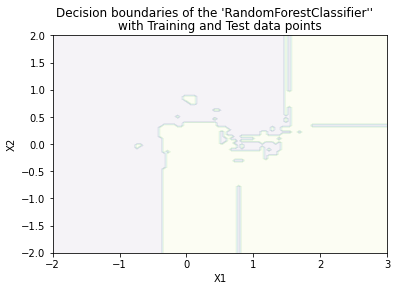

In [41]:
plot_decision_boundaries2D(clf_rndpaste, X_train, X_test, y_train, y_test, plot_train=False, plot_test=False)

<font color=blue>Which of the two methods has a lower variance in this case? Bagging or pasting?</font>

---

The decision boundary of the bagging is smoother than the boundary of pasting. Thus bagging has a lower variance. This is because bagging introduces more diversity in training of the esitimators. Therefore, the variance of the base estimator is usually reduced more with bagging. 

---

## Boosting

We generate a new dataset for the remaining part of the session.

In [42]:
def make_sinusoidal(random_state=None, max_x = 10., n_samples=200, noise=0.1, plot_=True):
    """Create a 1D sinusoidal dataset. Returns X, y."""
    rng = np.random.RandomState(random_state)
    X = np.sort(max_x * rng.rand(n_samples, 1), axis=0)
    y = np.sin(X).ravel() + noise * rng.randn(n_samples)
    if plot_:
        plt.scatter(X, y, color="darkorange", marker=".")
        plt.xlabel("X")
        plt.ylabel("y")
        plt.title(f"n_samples:{n_samples}")
        plt.show()
        plt.close()
    return X, y

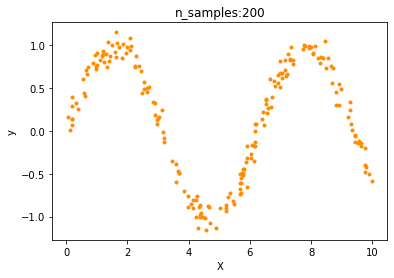

In [43]:
X, y = make_sinusoidal(RANDOM_SEED)

And, we create our new train and tests sets.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

We define a function for the plots below that you will use as-is. See how the [Mean Absolute Errors](https://en.wikipedia.org/wiki/Mean_absolute_error) (MAEs) are calculated w.r.t the true function and the test set.

In [45]:
def plot_prediction(true_f, fit_predictor, X_train, X_test, y_train, y_test, n_points=100):
    """Plots the true underlying function, training data and predictions and computes MAEs."""
    # Prediction points for plotting only
    X_plot = np.linspace(X_train.min(), X_train.max(), n_points)[:, np.newaxis]
    # Training data
    plt.scatter(X_train, y_train, color="darkorange", marker=".", label="training data")
    # True underlying function
    plt.plot(X_plot, true_f(X_plot), color="red", linewidth=2, linestyle="-", alpha=0.7, label="true function")
    # Predictions for the X_plot
    plt.plot(X_plot, fit_predictor.predict(X_plot), color="royalblue", linewidth=2, linestyle="-", label="prediction")
    # Mean Absolute Errors
    y_true = true_f(X_test).reshape(-1)
    y_pred = fit_predictor.predict(X_test)
    mae_true = np.mean(np.abs(y_true - y_pred))  # MAE on true function
    mae_test = np.mean(np.abs(y_test - y_pred))  # MAE on test set
    plt.title(f"MAE True:{mae_true:.4f}, MAE Test:{mae_test:.4f}")
    plt.legend()
    plt.show()

<font color=blue>Fit a Regression Tree to the sinusosidal data. Set the tree's maximum depth to 5 and random state to `RANDOM_SEED`.</font>

In [46]:
from sklearn.tree import DecisionTreeRegressor

reg_tree5 = DecisionTreeRegressor(max_depth=5, random_state=RANDOM_SEED)

reg_tree5.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=0)

Let's plot the predictions of the tree. Observe that a tree of depth 5 more or less fits the data, i.e., it is neither overfitting nor too underfitting.

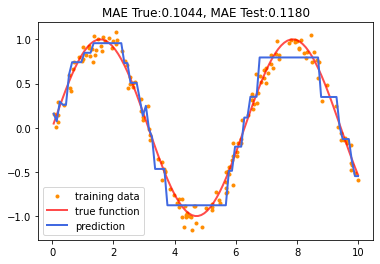

In [47]:
plot_prediction(np.sin, reg_tree5, X_train, X_test, y_train, y_test)

### AdaBoost

Now, we will use the [sklearn.ensemble.AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html) regressor to boost our single tree and see if we can have an ensemble that generalizes better.

<font color=blue>Fit a `AdaBoostRegressor` to the sinusoidal training data above with the following parameters:<br/>- Use `20` Regression Trees with maximum depth of `5`;<br/>- Set learning rate to `1`<br/>- Set the random state to `RANDOM_SEED`.</font> 

In [48]:
from sklearn.ensemble import AdaBoostRegressor

reg_ada5 = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=5), 
    n_estimators=20,
    learning_rate=1.,
    random_state=RANDOM_SEED)

reg_ada5.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5),
                  n_estimators=20, random_state=0)

Let's see how the boosted ensembele performs.

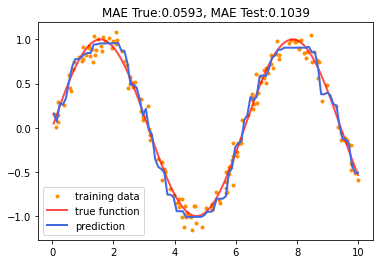

In [49]:
plot_prediction(np.sin, reg_ada5, X_train, X_test, y_train, y_test)

<font color=blue>Interpret the Mean Absolute Errors of the single Decision Tree (`reg_tree5`) and AdaBoost (`reg_ada5`) regressors.</font>

---

AdaBoost clearly boosted the single decision tree's performance. We can see this both visually (the prediction  follows the true function more fluently) and by comparing the errors of the two models. The performance boost happened thanks to the fact that each tree in the ensemble learned to perform better on the training instances that were not predicted well by the previous tree. And the aggregation of the ensemble's trees predictions was more accurate than our single tree.

---


### Gradient Boosting

We start with implementing our custom Gradient Boosting Regressor.

<font color=blue>Fill in the indicated three lines with your code. Each line should end up as a single line.<br/>HINT: See the pseudocode in the lecture slides.</font>

In [50]:
class MyGradientTreeBoostingRegressor:
    """Custom Gradient Boosting Regressor with Decision Tree as the base estimator."""
    
    def __init__(self, n_estimators=100, max_depth=3, learning_rate=0.1, random_state=None):
        self.learning_rate = learning_rate
        self.M = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.hypotheses = []  # i.e., trees
        
    def fit(self, X, y):  
        
        self.F_0 = y.mean()  # <--
        F_m = self.F_0
        
        for m in range(self.M):
            r_m = y - F_m
            h_m = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            h_m.fit(X, r_m)
            gamma_m = h_m.predict(X)
            F_m = F_m  + self.learning_rate * gamma_m  # <--
            self.hypotheses.append(h_m)
            
    def predict(self, X): 
        
        F_m = self.F_0
        
        for m in range(self.M):
            F_m = F_m  + self.learning_rate * self.hypotheses[m].predict(X)  # <--
            
        return F_m

We fit our Gradient Booster to the sinusoidal data.

In [51]:
reg_my_gtb = MyGradientTreeBoostingRegressor(
    n_estimators=1000, 
    max_depth=1,
    learning_rate=0.1, 
    random_state=RANDOM_SEED
)
reg_my_gtb.fit(X, y)

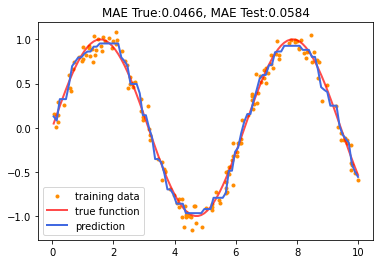

In [52]:
plot_prediction(np.sin, reg_my_gtb, X_train, X_test, y_train, y_test)

<font color=blue>Fit a [`sklearn.ensemble.GradientBoostingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) to the sinusoidal training data above with the same parameters we used initiating our own MyGradientTreeBoostingRegressor. Then, plot the predictions.</font>

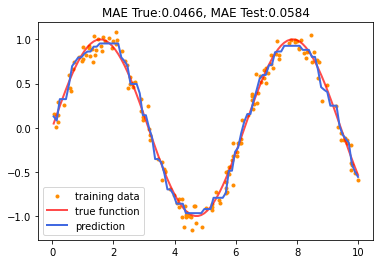

In [53]:
from sklearn.ensemble import GradientBoostingRegressor

reg_sklearn_gtb = GradientBoostingRegressor(
    n_estimators=1000, 
    max_depth=1,
    learning_rate=0.1, 
    random_state=RANDOM_SEED)

reg_sklearn_gtb.fit(X, y)

plot_prediction(np.sin, reg_sklearn_gtb, X_train, X_test, y_train, y_test)

OMG! Our own Gradient Boosting implementation and scikit-learn's yielded identical results! (At least, they should have!) Congratulations! 👏 <br/>
Note that with only decision stumps&mdash;well, with a thousand of them&mdash;we have been able to generalize almost perfectly despite the noise in the data! This is pretty amazing, isn't it?😃